<a href="https://colab.research.google.com/github/asotjrs/Deep-learning-with-pytorch/blob/main/Pytorch_Paper_Research_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Replicating the ViT Paper

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 112.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.

torch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3768, done.
remote: Counting objects: 100% (390/390), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 3768 (delta 209), reused 321 (delta 168), pack-reused 3378
Receiving objects: 100% (3768/3768), 648.94 MiB | 14.69 MiB/s, done.
Resolving deltas: 100% (2165/2165), done.
Updating files: 100% (248/248), done.


In [3]:
#setup device agnostic code 
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
 # Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

##2.create dataset and dataloaders

In [6]:
IMG_SIZE=224

manual_transforms=transforms.Compose(
    [
        transforms.Resize([IMG_SIZE,IMG_SIZE]),
        transforms.ToTensor()
    ]
)

manual_transforms

Compose(
    Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f61693088b0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

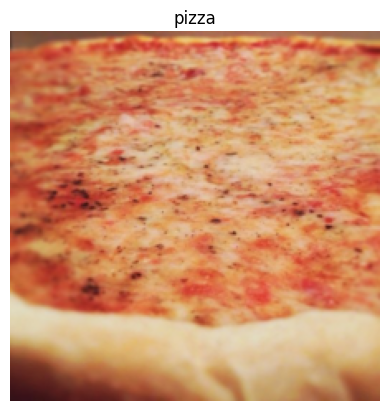

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [10]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


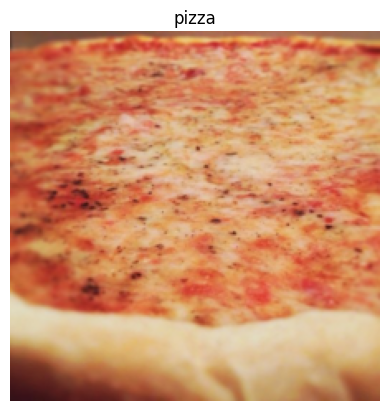

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

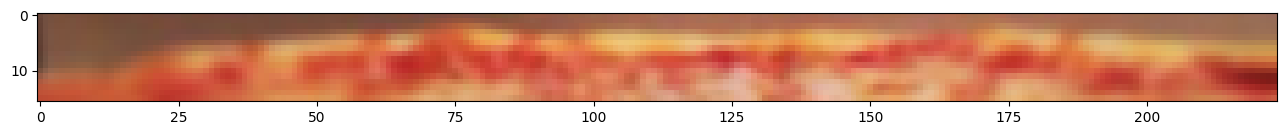

In [13]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


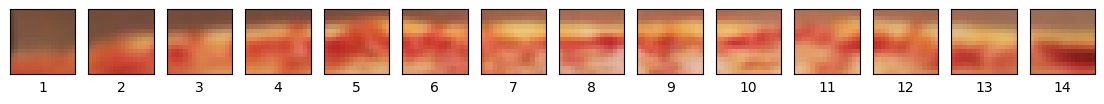

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


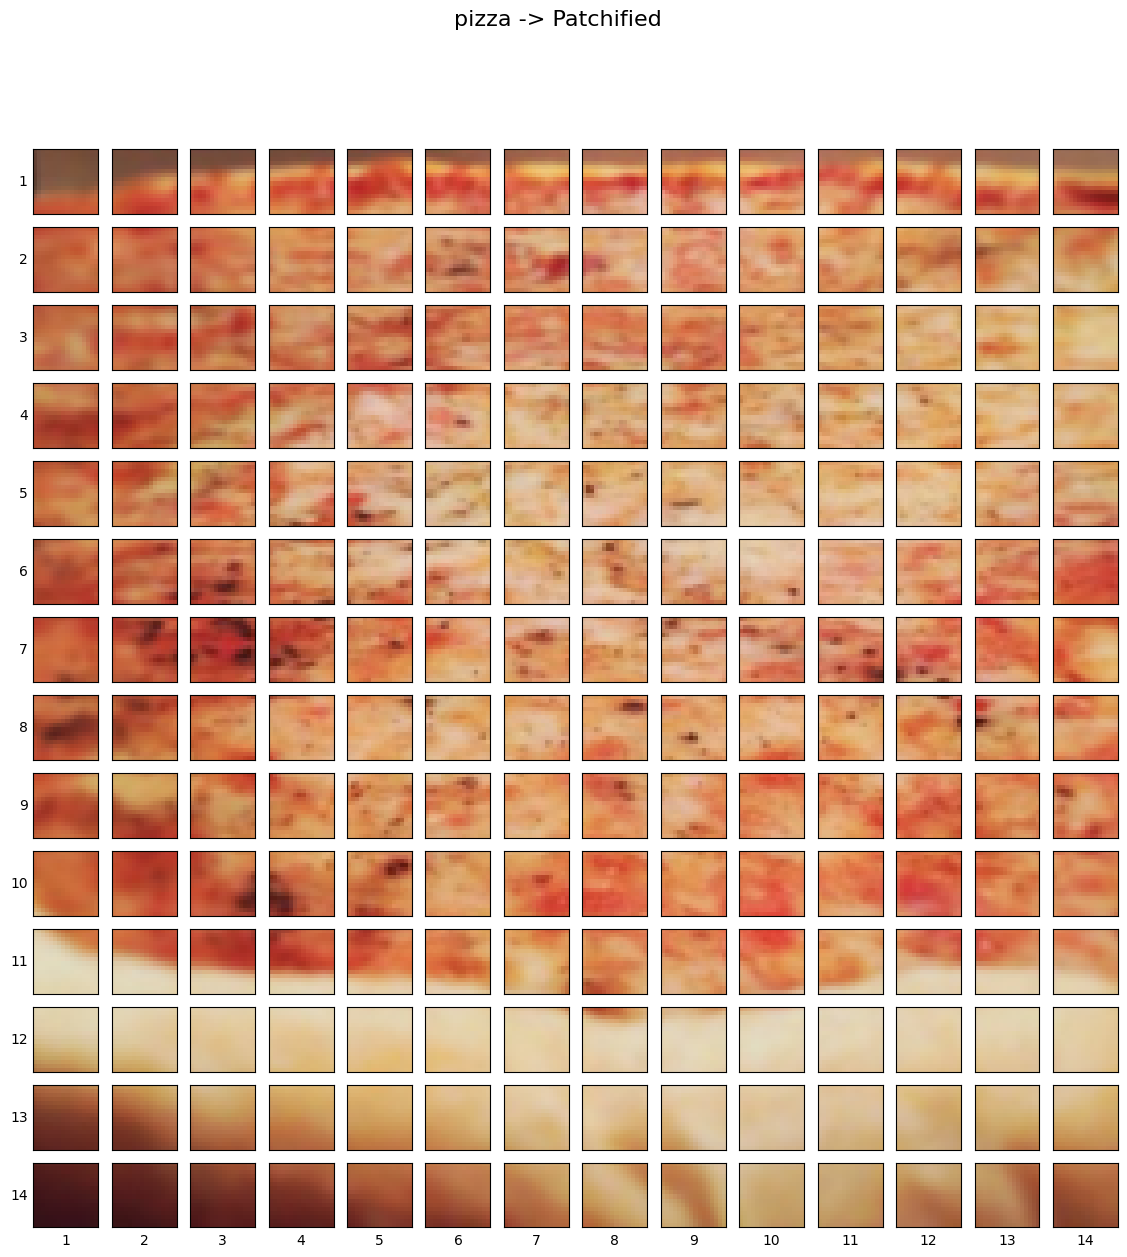

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

###Creating image patches and turning them into embeddings

In [16]:
from torch import nn 
 #set the patch size
patch_size=16
#create the Conv2D layer with hyperparameters from the ViT paper
conv2d= nn.Conv2d(in_channels=3, #number of color channels
                  out_channels=768, #from table 1 Hidden size D, this is the embedding size
                  kernel_size=patch_size, #could also use (patch_size,patch_size)
                  stride=patch_size,
                  padding=0
                  )

In [17]:
#pass the image through a convolutional layer
image_out_of_conv =conv2d(image.unsqueeze(0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Showing random convolutional feature maps from indexes: [588, 507, 40, 56, 234]


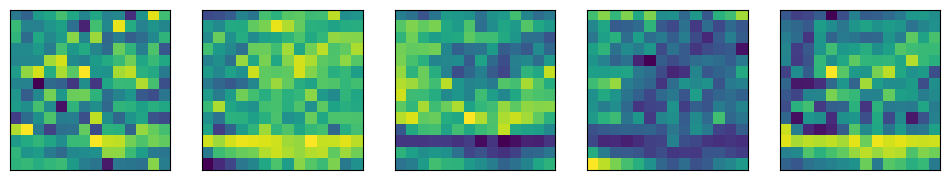

In [18]:
 # Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [19]:
single_feature_map=image_out_of_conv[:,0,:,:]
single_feature_map.requires_grad

True

In [20]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [21]:
#create a flatten layer
flatten=nn.Flatten(start_dim=2, #flatten feature map height (dim 2)
                    end_dim=3) #flatten  feature_map_width (dim 3)
                  

####Putting everything together

Original image shape: torch.Size([3, 224, 224])
Image Feature map shape:torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


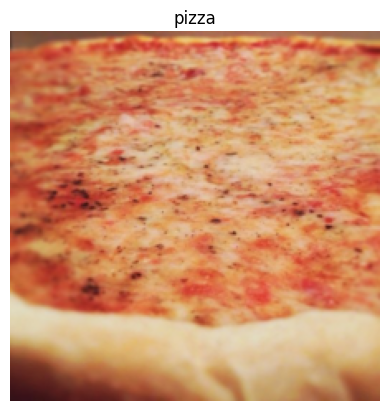

In [22]:
# 1. View a single image
plt.imshow(image.permute(1,2,0)) #adjust it for matplotlib 
plt.title(class_names[label]) 
plt.axis(False)
print(f'Original image shape: {image.shape}')

#2.turn image into feature maps
image_out_of_conv= conv2d(image.unsqueeze(0))#add a batch dimension to avoid shape error
print(f'Image Feature map shape:{image_out_of_conv.shape}')

#3. Flatten the feature maps
image_out_of_conv_flattened =flatten(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened.shape}')


In [23]:
#get the flattened image patch embeddings in the right shape
image_out_of_conv_flattened_reshaped=image_out_of_conv_flattened.permute(0,2,1) #[batch_size,P²*C,N]-> [batch_size,N,P²*C]
print(f'Patch embeddings sequence shape: {image_out_of_conv_flattened_reshaped.shape} ->[batch_size,num_patches,embedding_size]')


Patch embeddings sequence shape: torch.Size([1, 196, 768]) ->[batch_size,num_patches,embedding_size]


(-0.5, 195.5, 0.5, -0.5)

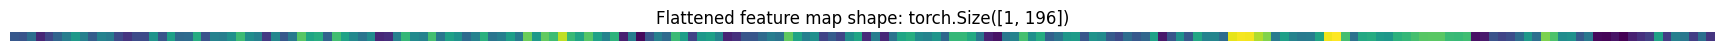

In [24]:
#get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]
#plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

### Turning the ViT patchembedding layer into a Pytorch Module


In [25]:
#create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
  """Turns a 2D input image into a 1D Sequence Learnable embedding vector.

  Args:
    in_channels(int): Number of color channels for the input images.
    patch_size(int): Size of patches to convert input images into Default to 16.
    embedding_dim(int): Size of embeddings to turn image into. Default to 768
  """ 
  #2 initialize the class with appropriate variables
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()

    #create a layer to turn image to patches
    self.patcher=nn.Conv2d(
        in_channels,
        out_channels=embedding_dim,
        kernel_size=patch_size,
        stride=patch_size,
        padding=0)
    #create a layer to flatten the patch featuremaps into a single dimension
    self.flatten=nn.Flatten(start_dim=2, #only flatten the feature map dimension into a single vector
                            end_dim=3)
  #define the forward method
  def forward(self,x):
    #create assertion to check that inputs are th correct shape
    image_resolution= x.shape[-1]
    assert image_resolution % patch_size == 0 , f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    #Perform the forward pass
    x_patched =self.patcher(x)
    x_flattened=self.flatten(x_patched)
    # Make sure  the output shape has the right order
    return x_flattened.permute(0,2,1) #adjust the embedding is on the finaldim [batch_size,P²C,N]-> [batch_size,N,P²C]

In [26]:
set_seeds()
#create an instance of patch embeding layer
patchify=PatchEmbedding(in_channels=3,patch_size=16,embedding_dim=768)
#pass a single image through
print(f"Input Image shape :{image.unsqueeze(0).shape}")
patch_embedded_image=patchify(image.unsqueeze(0)) #add an extra batch dimension on the 0th index, otherwise will error out (i think this is only for some versions)
print(f'Output patch embedding shape: {patch_embedded_image.shape}')

Input Image shape :torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [27]:
 #Create random input sizes
random_input_image=torch.randn(1,3,224,224)
random_input_image_error=torch.randn(1,3,250,250) #this will error out bcs image size is incompatible with patch size
#patchify(random_input_image_error)

###Creating a class token embeddings

In [28]:
#view patch embedding and patch embedding shape
print(patch_embedded_image)
print(f'Patch embedding shape: {patch_embedded_image.shape}')

tensor([[[-0.5250, -0.0300, -0.0381,  ...,  0.3208, -0.2333,  0.2396],
         [-0.5997, -0.0368, -0.0322,  ...,  0.2903, -0.2381,  0.2660],
         [-0.6602,  0.0743, -0.0904,  ...,  0.3584, -0.2738,  0.2541],
         ...,
         [-0.6368,  0.0921, -0.0420,  ...,  0.3776, -0.3795,  0.2150],
         [-0.5301,  0.0295, -0.1243,  ...,  0.3525, -0.3085,  0.2194],
         [-0.5054,  0.0627, -0.0332,  ...,  0.2973, -0.2927,  0.1290]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768])


In [29]:
#get the batch size and embedding dimension
batch_size=patch_embedded_image.shape[0]
embedding_dimesion=patch_embedded_image.shape[-1]
#create the class token embedding as a learnable parameter that shares the same size as the embedding dimension D
class_token =nn.Parameter(torch.ones(batch_size,1,embedding_dimesion),requires_grad=True) #make sure the embedding is learnable
#show first 10 examples of the class token
#class_token[:,:,:10]
#print the shape
class_token.shape

torch.Size([1, 1, 768])

In [30]:
#add the class token embedding to te front of the patch embedding
patch_embedded_image_with_class_embedding=torch.cat((class_token,patch_embedded_image),
                                                     dim=1) #concat the first dimension
#print thesequence pf patch embedings with prepended class token embedding
patch_embedded_image_with_class_embedding,patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5250, -0.0300, -0.0381,  ...,  0.3208, -0.2333,  0.2396],
          [-0.5997, -0.0368, -0.0322,  ...,  0.2903, -0.2381,  0.2660],
          ...,
          [-0.6368,  0.0921, -0.0420,  ...,  0.3776, -0.3795,  0.2150],
          [-0.5301,  0.0295, -0.1243,  ...,  0.3525, -0.3085,  0.2194],
          [-0.5054,  0.0627, -0.0332,  ...,  0.2973, -0.2927,  0.1290]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

###Creating the position embedding 

In [31]:
#Calculate N (number of patches)
number_of_patches= int ((height*width)/patch_size**2)
#get embedding dimension
embedding_dimension=patch_embedded_image_with_class_embedding.shape[-1]

#create a learnable 1D position embedding 
position_embedding =nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),
                                 requires_grad=True) #make sure its learnable
#show the first 1O sequences and 10 position embedding values and check the shape of position embedding
position_embedding[:,:10,:10], position_embedding.shape

(tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>),
 torch.Size([1, 197, 768]))

In [32]:
#add the position embedding to the patch class tokenembedding
patch_and_position_embedding=patch_embedded_image_with_class_embedding +position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.4750, 0.9700, 0.9619,  ..., 1.3208, 0.7667, 1.2396],
          [0.4003, 0.9632, 0.9678,  ..., 1.2903, 0.7619, 1.2660],
          ...,
          [0.3632, 1.0921, 0.9580,  ..., 1.3776, 0.6205, 1.2150],
          [0.4699, 1.0295, 0.8757,  ..., 1.3525, 0.6915, 1.2194],
          [0.4946, 1.0627, 0.9668,  ..., 1.2973, 0.7073, 1.1290]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [34]:
set_seeds()
#set patch size
patch_size=16
height,width=image.shape[1],image.shape[2]
#get image tensor and add batch dimension
x=image.unsqueeze(0)

#create a patch embedding layer
patch_embedding_layer=PatchEmbedding(in_channels=3,patch_size=patch_size,embedding_dim=768)
#pass the image through the patch embedding layer
patch_embedding=patch_embedding_layer(x)

#create a class token embedding
batch_size= patch_embedding.shape[0]
embedding_dimension=patch_embedding.shape[-1]
class_token=nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
#prepend class token embedding to patch emedding
patch_embedding_class_token=torch.cat((class_token,patch_embedding),dim=1)
#create a position embedding
number_of_patches=int((height*width)/patch_size**2)
position_embedding=nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),
                                requires_grad=True)
#add position embedding to patch embedding with class token
patch_and_position_embedding=patch_embedding_class_token+position_embedding

patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.4750, 0.9700, 0.9619,  ..., 1.3208, 0.7667, 1.2396],
          [0.4003, 0.9632, 0.9678,  ..., 1.2903, 0.7619, 1.2660],
          ...,
          [0.3632, 1.0921, 0.9580,  ..., 1.3776, 0.6205, 1.2150],
          [0.4699, 1.0295, 0.8757,  ..., 1.3525, 0.6915, 1.2194],
          [0.4946, 1.0627, 0.9668,  ..., 1.2973, 0.7073, 1.1290]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

##Equation 2: MultiHead Self-Attention (MSA Block)

In [43]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates multi-head self-attention block ("MSA block" for short).
  """
  #initialize the class with hyperparameters from table 1
  def __init__(self,
               embedding_dim:int=768, #hidden size D from Table 1 for ViT base
               num_heads:int=12,#heads from Table1 for ViT base
               attn_dropout:float=0): #doesn't look like the paper uses any dropout in the MSA block
    super().__init__()
    #create the Norm layer LN
    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)
    #create Multi-head Attention MSA Layer
    self.multihead_attn=nn.MultiheadAttention(embed_dim=embedding_dim,
                                              num_heads=num_heads,
                                              dropout=attn_dropout,
                                              batch_first=True ) #does our batch dimension came first
  #create a forward method to pass the data through the layer
  def forward(self,x):
    x=self.layer_norm(x)
    attn_output, _ =self.multihead_attn(query=x, #query embeddings
                                        key=x, #key embedding
                                        value=x, #value embedding
                                        need_weights=False) #we do not need the weights, only the layer output
    return attn_output 


In [46]:
#create an instance of MSA Block
multi_head_self_attention_block=MultiHeadSelfAttentionBlock(768,12,0)
#pass the patch and position image embedding  sequence through the msa block
patch_img_through_msa_block=multi_head_self_attention_block(patch_and_position_embedding)
patch_img_through_msa_block.shape

torch.Size([1, 197, 768])

###Multi Lyaer Preceptron Block

In [48]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [52]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1 
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patch_img_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])
